# Introduction to Crunchers

In this notebook we demonstrate crunchers, silicone's most fundamental infilling methods. You will need to install silicone from as described in the readme in order to run this code. It introduces two specific crunchers and the basic tools to manipulate them. These two are the 'closest RMS' and the 'rolling window quantile' crunchers. 

## Imports

In [1]:
import os.path
import traceback

import pandas as pd
import pyam
import matplotlib.pyplot as plt
import numpy as np

import silicone.database_crunchers
from silicone.utils import (
    _get_unit_of_variable,
    find_matching_scenarios,
    _make_interpolator,
    _make_wide_db, 
    get_sr15_scenarios
)

<IPython.core.display.Javascript object>

pyam - INFO: Running in a notebook, setting `pyam` logging level to `logging.INFO` and adding stderr handler


## Assembling example data

Here we pull some example data by downloading it from the IAMC 1.5°C Scenario Explorer and Data hosted by IIASA (for details, see Huppman et al 2019, Integrated Assessment Modeling Consortium & International Institute for Applied Systems Analysis, 2018). If the data has already been downloaded before, we will use that instead for brevity. We select only a few cases

In [2]:
valid_model_ids = [
        "MESSAGE*",
        "AIM*",
        "C-ROADS*",
        "GCAM*",
        #"IEA*",
        #"IMAGE*",
        #"MERGE*",
        #"POLES*",
        #"REMIND*",
        "WITCH*"
    ]
SR15_SCENARIOS = "./sr15_scenarios.csv"
if not os.path.isfile(SR15_SCENARIOS):
    get_sr15_scenarios(SR15_SCENARIOS, valid_model_ids)

### Starting point

Our starting point is the test data, loaded as a `pyam.IamDataFrame`. It may be helpful for understanding some of this tutorial for you to know more about IamDataFrames, documented at https://pyam-iamc.readthedocs.io/en/latest/. The key functions are `.filter()`, which selects a subset of data, and `.timeseries()`, which restructures the data into columns by date, with long indexes containing information other than the value. 

In [3]:
sr15_data = pyam.IamDataFrame(SR15_SCENARIOS)
sr15_data.timeseries().head()

pyam.utils - INFO: Reading `./sr15_scenarios.csv`


2000  \
model       scenario               region variable                                           unit      subannual meta         
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0.0       0      NaN   
                                          Emissions|CH4                                      Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0.0       0      NaN   

                                                                                                                           2005  \
model       scenario               region variable                                           unit      subannual meta             
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0.0       0       8.3367   
                                          Emissions|CH4                                      Mt CH4/yr 0.0       0     344.9167   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0.0       0     167.6717   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0.0       0       0.4732   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0.0       0      11.2639   

                                                                                                                           2010  \
model       scenario               region variable                                           unit      subannual meta             
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0.0       0       7.6408   
                                          Emissions|CH4                                      Mt CH4/yr 0.0       0     367.7457   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0.0       0     179.6356   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0.0       0       0.5168   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0.0       0      11.1249   

                                                                                                                       2014  \
model       scenario               region variable                                           unit      subannual meta         
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0.0       0      NaN   
                                          Emissions|CH4                                      Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr 0.0       0      NaN   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr 0.0       0      NaN   

                                                                                                                           2015  \
model       scenario               region variable                                           unit      subannual meta             
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr  0.0       0       7.2724   
                                          Emissions|CH4                                      Mt CH4/yr 0.0    

## Crunchers

Silicone's 'crunchers' are used to determine the relationship between a 'follower variable' and 'lead variable(s)' from a given database. The 'follower variable' is the variable for which we want to generate data e.g. `Emissions|C3F8` while the 'lead variable(s)' is the variable we want to use in order to infer a timeseries of the 'follower variable'. The lead variable is currently always a list with only a single item, e.g. `[Emissions|HFC]` but in future may be able to deal with several elements. The follower is always a single string - to infill multiple values in a collective way (e.g. splitting HFC into its various components) see Multiple Infillers. 

Each cruncher needs to be initialised with a database and has a `derive_relationship` method, which returns the infilling function. Its docstring describes what it does.

In [4]:
print(silicone.database_crunchers.base._DatabaseCruncher.derive_relationship.__doc__)
# # an alternative, pop-up interface is shown if you uncomment the line below
#silicone.database_crunchers.base._DatabaseCruncher.derive_relationship?


        Derive the relationship between two variables from the database

        Parameters
        ----------
        variable_follower : str
            The variable for which we want to calculate timeseries (e.g.
            ``"Emissions|C5F12"``).

        variable_leaders : list[str]
            The variables we want to use in order to infer timeseries of
            ``variable_follower`` (e.g. ``["Emissions|CO2", "Emissions|CH4"]``)

        **kwargs
            Keyword arguments used by this class to derive the relationship between
            ``variable_follower`` and ``variable_leaders``.

        Returns
        -------
        :obj:`func`
            Function which takes a :obj:`pyam.IamDataFrame` containing
            ``variable_leaders`` timeseries and returns timeseries for
            ``variable_follower`` based on the derived relationship between the two.
            Please see the source code for the exact definition (and docstring) of the
            returned functi

These crunchers are best explored by looking at the examples below.

### Closest Root Mean Square cruncher

This cruncher finds the scenario and model in the infiller database that minimises the RMS distance between the the lead emissions in the infiller and infillee data. The follow data is then directly taken from that scenario. 
The full documentation is as follows:

In [5]:
print(silicone.database_crunchers.DatabaseCruncherRMSClosest.__doc__)


    Database cruncher which uses the 'closest RMS' technkque.

    This cruncher derives the relationship between two variables by finding the
    scenario which has the closest lead gas timeseries in the database.  The follower
    gas timeseries is then simply copied from the closest scenario.

    Here, 'closest' is defined as the smallest time-averaged root mean squared (L2)
    difference.

    .. math::
        RMS = \left ( \frac{1}{n} \sum_{t=0}^n (E_l(t) - E_l^{d}(t))^2 \right )^{1/2}

    where :math:`n` is the total number of timesteps in the lead gas' timeseries,
    :math:`E_l(t)` is the lead gas emissions timeseries and :math:`E_l^d(t)` is a lead
    gas emissions timeseries in the database.
    


#### Infilling

Firstly, let's cut the database down to a size that is comprehensible.

In [2]:
sr15_data_closest_rms = sr15_data.filter(model=["WITCH-GLOBIOM 4.2"])
sr15_data_closest_rms.head()

NameError: name 'sr15_data' is not defined

Next, we initialise the type of cruncher we want with the infiller database. 

In [7]:
cruncher = silicone.database_crunchers.DatabaseCruncherRMSClosest(sr15_data_closest_rms)

Now we can derive the relationship between the follower and leader, here `Emissions|CO2` and `Emissions|VOC` respectively. This returns a infiller function, which we will use later. Firstly we will check out the docstring. 

In [8]:
filler = cruncher.derive_relationship("Emissions|VOC", ["Emissions|CO2"])
print(filler.__doc__)
# filler info:


            Filler function derived from :obj:`DatabaseCruncherRMSClosest`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled in data (without original source data)

            Raises
            ------
            ValueError
                If there are any inconsistencies between the timeseries, units or
                expectations of the program and ``in_iamdf``, compared to the database
                used to generate this ``filler`` function.
            


Now we can use this relationship to do some infilling. As a sanity check, we firstly make sure that if we pass in a CO$_2$ timeseries which is already in the database, we get back its VOC emissions timeseries. 

In [9]:
example_model_scen = {
    "model": "WITCH-GLOBIOM 4.2",
    "scenario": "ADVANCE_INDC",
}
example_input = sr15_data_closest_rms.filter(**example_model_scen).data
example_input["model"] = "example"
example_input["scenario"] = "example"
example_input = pyam.IamDataFrame(example_input)

We can now use the function we returned above to infill the example data, and see that we recover the data we put in. 

In [10]:
example_input_filled = filler(example_input)
example_input_filled.timeseries()

,,,,,,,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
model,scenario,region,variable,unit,subannual,meta,,,,,,,,,,,,,,,,,,,,
example,example,World,Emissions|VOC,Mt VOC/yr,0.0,0,189.212,164.056724,153.575866,145.611005,130.387433,115.465871,102.038923,89.302542,76.60488,62.855685,58.440154,56.971497,55.075327,53.101911,51.074418,49.558506,47.602518,45.377459,43.08547,41.400122


In [11]:
sr15_data_closest_rms.filter(variable="Emissions|VOC", **example_model_scen).timeseries()

,,,,,,,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
model,scenario,region,variable,unit,subannual,meta,,,,,,,,,,,,,,,,,,,,
WITCH-GLOBIOM 4.2,ADVANCE_INDC,World,Emissions|VOC,Mt VOC/yr,0.0,0,189.212,164.056724,153.575866,145.611005,130.387433,115.465871,102.038923,89.302542,76.60488,62.855685,58.440154,56.971497,55.075327,53.101911,51.074418,49.558506,47.602518,45.377459,43.08547,41.400122


As expected, the cruncher has picked out the scenario which matches and returned its VOC timeseries. This can also be seen in a plot below, where the dashed (infilled) line perfectly matches the pink line. 

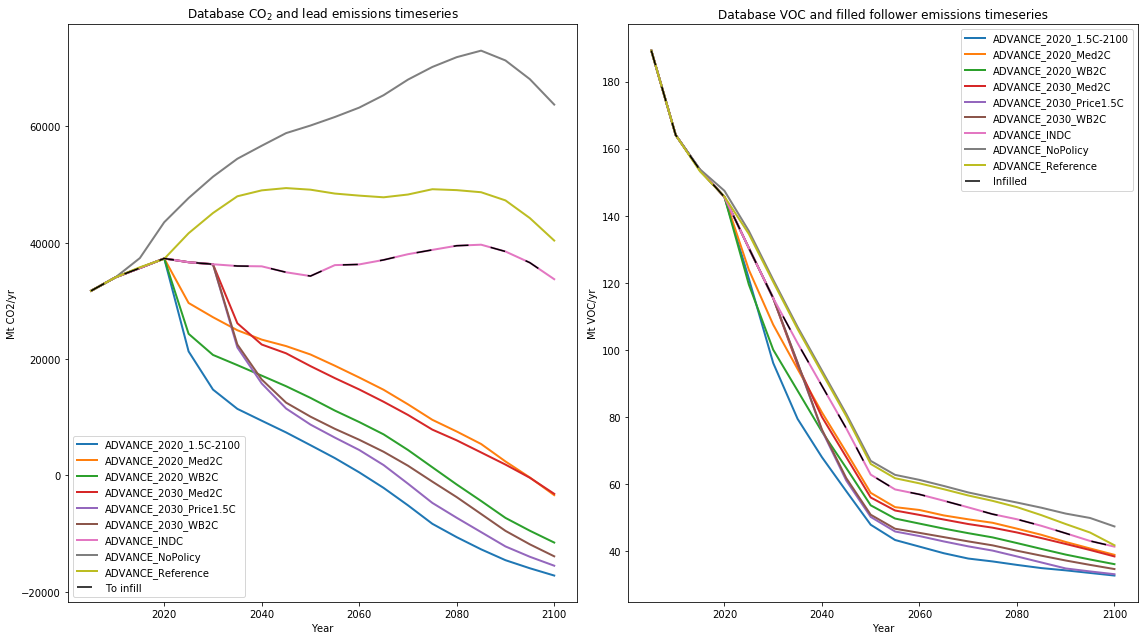

In [12]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_closest_rms.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
example_input.filter(variable="*CO2").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15), label="To infill")
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_closest_rms.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
example_input_filled.filter(variable="*VOC").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15), label="Infilled")
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

Now we can use our filler to infill other timeseries not present in our infiller database.

In [13]:
filler_input = sr15_data.filter(model="MESSAGEix-GLOBIOM 1.0", scenario="CD-LINKS_NPi2020_1600")
# This scenario is missing `Emissions|VOC`. 
filler_input.filter(variable="Emissions|VOC").data

pyam.core - WARNING: Filtered IamDataFrame is empty!


,model,scenario,region,variable,unit,year,subannual,meta,value


In [14]:
# It can go in the same infiller we defined previously.
filler_input_filled = filler(filler_input)

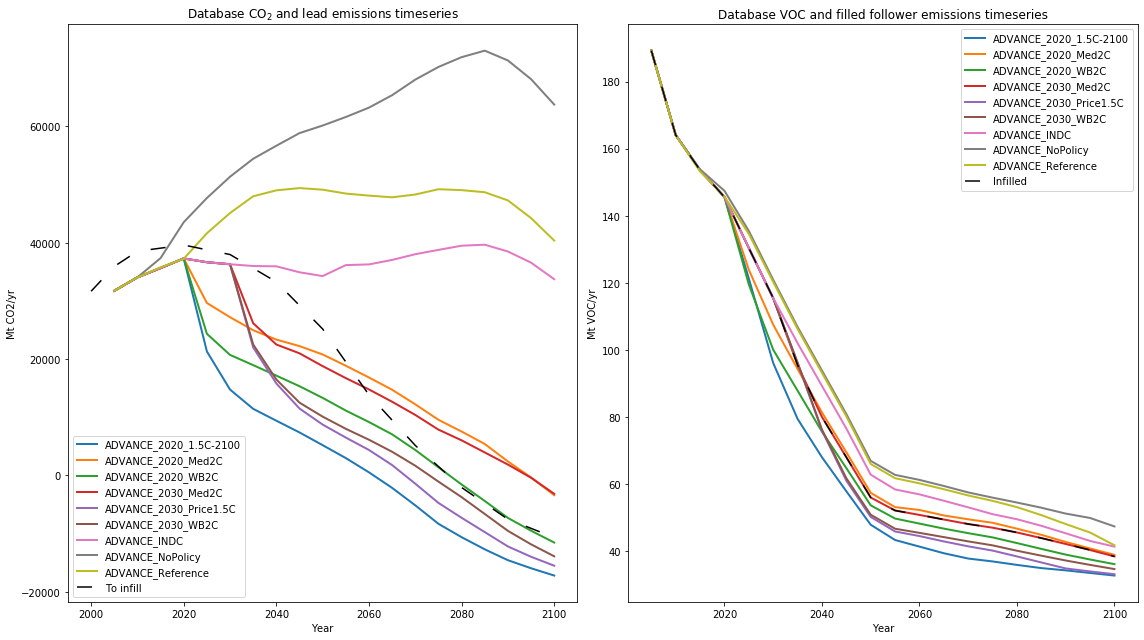

In [15]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_closest_rms.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
filler_input.filter(variable="*CO2").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15), label="To infill")
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_closest_rms.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
filler_input_filled.filter(variable="*VOC").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15), label="Infilled")
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

As we can see, on an RMS basis our input timeseries is closest to the 'ADVANCE_2030_Med2C' scenario and hence its `Emissions|VOC` pathway is returned.

In [16]:
filler_input_filled.timeseries()

,,,,,,,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
model,scenario,region,variable,unit,subannual,meta,,,,,,,,,,,,,,,,,,,,
MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,0.0,0,189.212,164.056724,153.575866,145.611005,130.387433,115.465871,95.506957,80.043895,68.04429,56.038428,52.164286,50.849028,49.479184,48.134296,47.046133,45.615107,43.948576,42.192038,40.390822,38.480263


In [17]:
sr15_data_closest_rms.filter(scenario="ADVANCE_2030_Med2C", variable="Emissions|VOC").timeseries()

,,,,,,,2005,2010,2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
model,scenario,region,variable,unit,subannual,meta,,,,,,,,,,,,,,,,,,,,
WITCH-GLOBIOM 4.2,ADVANCE_2030_Med2C,World,Emissions|VOC,Mt VOC/yr,0.0,0,189.212,164.056724,153.575866,145.611005,130.387433,115.465871,95.506957,80.043895,68.04429,56.038428,52.164286,50.849028,49.479184,48.134296,47.046133,45.615107,43.948576,42.192038,40.390822,38.480263


This may be regarded as conceptually the simplest of the crunchers. We will introduce one other in this workbook, and then several in the next. 

### Rolling Window Quantile cruncher

This cruncher takes a more statistical approach. It calculates a given quantile of the relationship between lead and follow data in the infiller database, then infills the corresponding value for the infillee data. By default this quantile is 0.5, i.e. we infill the median value. It may be considered the default cruncher. It is described by its docstring:

In [18]:
print(silicone.database_crunchers.DatabaseCruncherQuantileRollingWindows.__doc__)
# silicone.database_crunchers.DatabaseCruncherQuantileRollingWindows?


    Database cruncher which uses the 'rolling windows' technique.

    This cruncher derives the relationship between two variables by performing
    quantile calculations between the follower timeseries and the lead timeseries.
    These calculations are performed at each timestep in the timeseries, independent
    of the other timesteps.

    For each timestep, the lead timeseries axis is divided into multiple evenly spaced
    windows (to date this is only tested on 1:1 relationships but may work with more
    than one lead timeseries). In each window, every data point in the database is
    included. However, the data points receive a weight given by

    .. math::

        w(x, x_{\text{window}}) = \frac{1}{1 + (d_n)^2}

    where :math:`w` is the weight and :math:`d_n` is the normalised distance between
    the centre of the window and the data point's position on the lead timeseries axis.

    :math:`d_n` is calculated as

    .. math::

        d_n = \frac{x - x_{\text{window}

#### Infilling

Because it relies on quantile analysis, this cruncher does best with large amounts of data (though filtering out irrelevant scenarios can still be helpful). It also only returns values found in the database (unless `use_ratio` is `True`), so will produce more variation the more data it is given. We filter results in this example to improve the runtime. In most cases we will not want to change the quantile from 0.5. 

In [19]:
sr15_data_quantile = sr15_data.filter(
    model=["WITCH-GLOBIOM 4.2"], variable=["Emissions|CO2", "Emissions|VOC"]
)

In [20]:
cruncher = silicone.database_crunchers.DatabaseCruncherQuantileRollingWindows(sr15_data_quantile)

In [21]:
filler = cruncher.derive_relationship("Emissions|VOC", ["Emissions|CO2"])
print(filler.__doc__)


            Filler function derived from :obj:`DatabaseCruncherQuantileRollingWindows`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled in data (without original source data)

            Raises
            ------
            ValueError
                The key db_times for filling are not in ``in_iamdf``.
            


Now we can infill a different scenario. 

In [22]:
filler_input = sr15_data.filter(model="MESSAGEix-GLOBIOM 1.0", scenario="CD-LINKS_NPi2020_1600")

The `filler_input` is missing `Emissions|VOC`.

In [23]:
filler_input.filter(variable="Emissions|VOC").data

pyam.core - WARNING: Filtered IamDataFrame is empty!


,model,scenario,region,variable,unit,year,subannual,meta,value


The rolling windows quantile can only work on the timesteps in the infiller database. If we input times that aren't there, we will receive a `ValueError`.

In [24]:
try:
    filler(filler_input)
except ValueError:
    traceback.print_exc(limit=0, chain=False)

Traceback (most recent call last):
ValueError: Not all required timepoints are present in the database we crunched, we crunched 
	`[2005, 2010, 2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100]`
but you passed in 
	[2000, 2005, 2010, 2015, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]


We can fix this by filtering the years we ask for, or using a bigger infiller database.

In [25]:
filler_data = filler_input.filter(year=sr15_data_quantile["year"].unique(), variable="Emissions|CO2")
filler_data.timeseries()

,,,,,,,2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
model,scenario,region,variable,unit,subannual,meta,,,,,,,,,,,
MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|CO2,Mt CO2/yr,0.0,0,35933.0697,38542.01816,39615.22255,37981.07524,33271.92656,25181.95619,13847.19271,5163.226383,-2068.503671,-7525.726077,-10662.64286


Now we can infill:

In [26]:
filled = filler(filler_data)
filled.head()

,model,scenario,region,variable,unit,year,subannual,meta,value
0,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2005,0.0,0,189.212000
1,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2010,0.0,0,164.056724
2,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2020,0.0,0,145.611005
3,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2030,0.0,0,115.465871
4,MESSAGEix-GLOBIOM 1.0,CD-LINKS_NPi2020_1600,World,Emissions|VOC,Mt VOC/yr,2040,0.0,0,89.302542


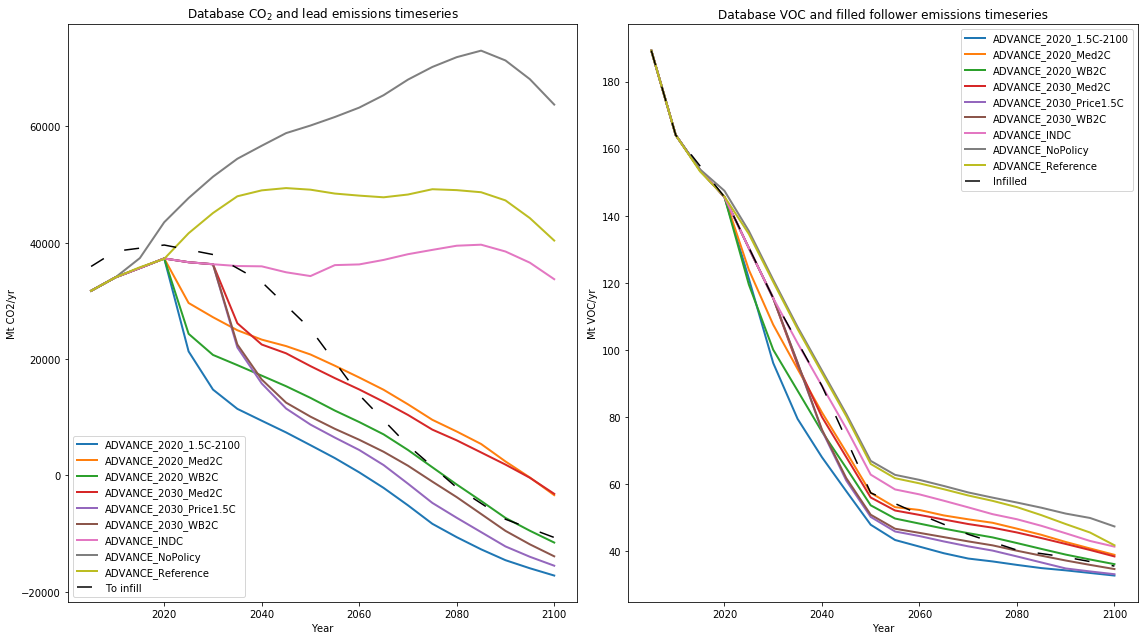

In [27]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_quantile.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
filler_data.filter(variable="*CO2").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15), label="To infill")
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_quantile.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
filled.filter(variable="*VOC").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15), label="Infilled")
ax.set_title("Database VOC and filled follower emissions timeseries")

plt.tight_layout()

The quantiles do not stick to a single timeline, so unlike in the case above, we can move between different values found in the infiller database. However we still cannot move outside of it. 

#### Recovering the data you put in

This section does not illustrate new functionality, merely investigates the mathematical effects of changing the number of windows.

Because of the averaging mechanism, the cruncher will only precisely reproduce the input data when there is only one timeseries in the infiller database. With multiple data series, this is not guaranteed, although will happen in the limit case of very localised weighting, represented by changing either `nwindows` or `decay_length_factor`. Both of these refer to how the rolling windows are calculated. The first of these controls how many points the windows are calculated at, the second weights points closer to the window center more strongly. The mathematical details can be found in the documentation, but we generally do not advise changing `decay_length_factor`. We explore below the effects of using the whole database on the infiller. 

In [28]:
# Multiple data are input - the 50th percentile and nwindows=10 is the default
filler_data = sr15_data_quantile.filter(scenario='ADVANCE_2030_Med2C')
self_cruncher = silicone.database_crunchers.DatabaseCruncherQuantileRollingWindows(sr15_data)
self_filler_default = self_cruncher.derive_relationship("Emissions|VOC", ["Emissions|VOC"], nwindows=10)
infilled_quantile = self_filler_default(filler_data)

The default behaviour shows the correct trend, but the windows-based interpolation introduces some noise.

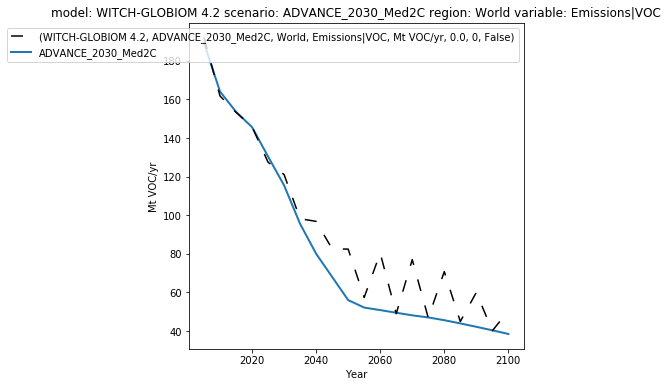

In [29]:
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
filler_data.filter(variable='Emissions|VOC', ).line_plot(ax=ax, **pkwargs)
infilled_quantile.filter(variable='Emissions|VOC').line_plot(ax=ax, color="black", linestyle="--", dashes=(8, 10))
# To see all the infiller data, uncomment the line below:
# sr15_data.filter(variable='Emissions|VOC',).line_plot(ax=ax, linewidth=0.1)

By increasing the windows number, we can get a higher fidelity - at the cost of more computational power and less averaging over different datapoints. 

In [30]:
# With a lower window number, the deviations become clearer
self_filler_low_w = self_cruncher.derive_relationship("Emissions|VOC", ["Emissions|VOC"], nwindows=2)
infilled_low_w = self_filler_low_w(filler_data)
# Higher window numbers mean that we weight data with the exact same x-value more highly, recovering the original relation
self_filler_high_w = self_cruncher.derive_relationship("Emissions|VOC", ["Emissions|VOC"], nwindows=30)
infilled_high_w = self_filler_high_w(filler_data)

Here the lower window count (blue) results in large deviations from the local data (towards to median value at that time) whereas the high window case (red) provides a close match. If you want to see all the trend lines on the graph at the same time, uncomment a line below. 

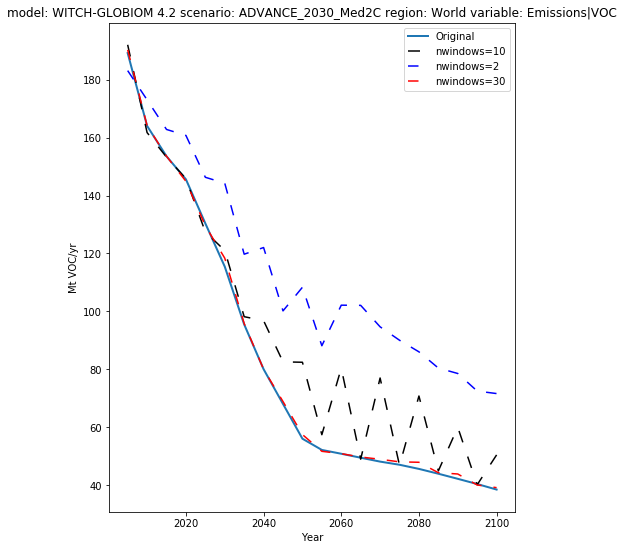

In [31]:
pkwargs = {"color": "scenario", "linewidth": 2}
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
filler_data.filter(variable='Emissions|VOC', ).line_plot(ax=ax, **pkwargs)
infilled_quantile.filter(variable='Emissions|VOC').line_plot(ax=ax, color="black", linestyle="--", dashes=(8, 10))
infilled_low_w.line_plot(ax=ax, color="blue", linestyle="--", dashes=(7, 8))
infilled_high_w.line_plot(ax=ax, color="red", linestyle="--", dashes=(7, 8))
plt.legend(['Original', 'nwindows=10', 'nwindows=2', 'nwindows=30'])
# This line illustrates the background data informing the deviations (but confuses the plots). 
# Re-add it if desired:
# sr15_data.filter(variable='Emissions|VOC',).line_plot(ax=ax, linewidth=0.1)

#### Quantile rolling window ratio option
The quantile rolling window infiller has a `use_ratio` option that defaults to false. If set to true, instead of infilling the value found using the above process, it uses the ratio between the lead and follow data. This ratio is found using rolling weighted windows as above, and is typically the median value. Having found the ratio, it multiplies it by the value of the lead variable in the infillee database at the appropriate time. We recommend not to use this if the lead or follow variable changes sign. 

In [32]:
filler_input = sr15_data.filter(model="MESSAGEix-GLOBIOM 1.0", scenario="CD-LINKS_NPi2020_1600")
filler_data = filler_input.filter(year=sr15_data_quantile["year"].unique(), variable="Emissions|CO2")
filler = cruncher.derive_relationship("Emissions|VOC", ["Emissions|CO2"], use_ratio=True)
infilled = filler(filler_data)

The graphs below show that these results are also reasonable, and allow for infilled values outside the range in the infiller database. However there is some degree of irregularity when the lead variable goes negative, and potentially a sign error could occur here. 

Text(0.5, 1.0, 'Database VOC and filled follower emissions timeseries')

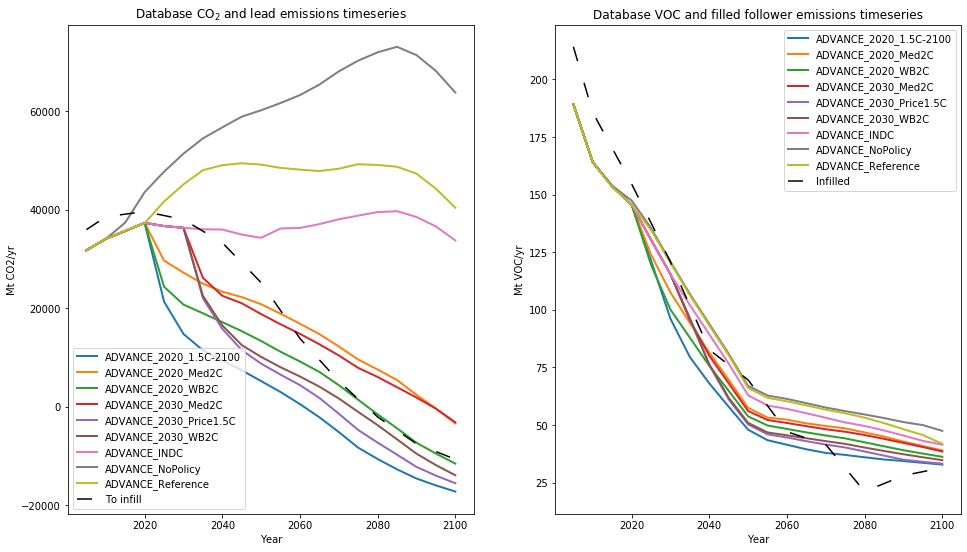

In [33]:
pkwargs = {"color": "scenario", "linewidth": 2}

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(121)
sr15_data_quantile.filter(variable="*CO2").line_plot(ax=ax, **pkwargs)
filler_data.filter(variable="*CO2").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15), label="To infill")
ax.set_title("Database CO$_2$ and lead emissions timeseries")

ax = fig.add_subplot(122)
sr15_data_quantile.filter(variable="*VOC").line_plot(ax=ax, **pkwargs)
infilled.filter(variable="*VOC").line_plot(ax=ax, color="black", linestyle="--", dashes=(10, 15), label="Infilled")
ax.set_title("Database VOC and filled follower emissions timeseries")

This concludes our introduction to infillers. Additional crunchers and when to filter the infiller database before using it are explained in the `more_crunchers` notebook. Techniques for simultaneously infilling multiple variables in a consistent way are found in `multiple_infillers`. 